In [1]:
import itertools
import matplotlib.pyplot
import pandas as pd
from pandas import DataFrame
import numpy as np
import math
from scipy.spatial import distance
import json
import ml.RL.bicycle_model
from analysis.lap_difference_analyzer import *
from analysis.log_file_analyzer import *
from ml.RL.bicycle_model import BicycleKinematicModel

In [2]:
reference_df = log_to_dataFrame("../test_data/kartfinal36pr3r.csv")
normalize_logs(reference_df)

traces_df = log_to_dataFrame("../test_data/200629130554_gps.log")
normalize_logs(traces_df)

laps = separate_laps(traces_df, reference_df)

reference_df['LAT'] = reference_df['LAT'].apply(lambda deg: degrees2kilometers(deg) * 1000)
reference_df['LON'] = reference_df['LON'].apply(lambda deg: degrees2kilometers(deg) * 1000)
reference_df['CRS'] = reference_df['CRS'].apply(lambda deg: np.deg2rad(deg))
# reference_df['CRS'] = reference_df['CRS'].apply(lambda deg: deg if not deg > math.pi else deg - 2*math.pi)

traces_df['LAT'] = traces_df['LAT'].apply(lambda deg: degrees2kilometers(deg) * 1000)
traces_df['LON'] = traces_df['LON'].apply(lambda deg: degrees2kilometers(deg) * 1000)
traces_df['CRS'] = traces_df['CRS'].apply(lambda deg: np.deg2rad(deg))
# traces_df['CRS'] = traces_df['CRS'].apply(lambda deg: deg if not deg > math.pi else deg - 2*math.pi)

228.14902044187227
219.10375000000002
(1953455.8698890596, 5342830.671894487)
Reference original: 1420
Index: 1420, Heading angle: 228.14902044187227, Target angle: 22.479434389308018
Index: 0, Heading angle: 228.14902044187227, Target angle: 228.14902044187227
Diff: 0.0, index: 0
(1953455.8098414645, 5342830.6048550485)
Reference original: 1420
Index: 1420, Heading angle: 228.14902044187227, Target angle: 23.702531306142387
Index: 0, Heading angle: 228.14902044187227, Target angle: 228.14902043950457
Diff: -3.4436897777823106e-12, index: 0
(1953455.7497938694, 5342830.5378156099)
Reference original: 1420
Index: 1420, Heading angle: 228.14902044187227, Target angle: 24.82063490494868
Index: 0, Heading angle: 228.14902044187227, Target angle: 228.1490204369477
Diff: -7.162492821066735e-12, index: 0
(1953455.6897462744, 5342830.4707761714)
Reference original: 1420
Index: 1420, Heading angle: 228.14902044188412, Target angle: 25.84595638476776
Index: 0, Heading angle: 228.14902044188412, 

KeyboardInterrupt: 

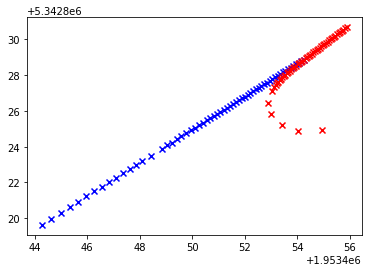

In [48]:
def n_wise(iterable, n):
    return zip(*(itertools.islice(iterable, i, None) for i in range(n)))

def get_angle(p0, p1, p2):
    ''' compute angle (in degrees) for p0p1p2 corner
    Inputs:
        p0,p1,p2 - points in the form of [x,y]
    '''
    v0 = np.array(p1) - np.array(p0)
    v1 = np.array(p2) - np.array(p1)

    angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
    return np.degrees(angle)

def find_nearest_coord(array, value):
  return min(array, key=lambda c: (c[0]- value[0])**2 + (c[1]-value[1])**2)

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2, positive=False):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
    """
    angle =  atan2( np.linalg.det(np.array(v1+v2).reshape((2,2))), np.dot(v1, v2) )
    if positive and angle < 0:
        angle += 2 * math.pi
    return angle

def getNewSteeringAngle(lap, reference_lap):
    points = [tuple(x) for x in lap[['LON', 'LAT']].to_numpy()]
    reference_points = [tuple(x) for x in reference_lap[['LON', 'LAT']].to_numpy()]

    for i in range(60):
        x,y = reference_points[i]
        matplotlib.pyplot.scatter(x, y, marker="x", color="blue")

    for i in range(len(points)):
        starting_point = points[i]
        x,y = starting_point
        xt, yt = reference_points[0]
        nearest_vector = (xt-x, yt-y)
        starting_heading_angle = angle_between((1,0), nearest_vector, True)
        print(math.degrees(starting_heading_angle))
        print(math.degrees(reference_lap.loc[i, 'CRS']))
        model = BicycleKinematicModel(x=starting_point[0],
                                      y=starting_point[1],
                                      heading_angle=starting_heading_angle,
                                      steering_angle=0)
        actual_index = 0
        while True:
            actual_state = model.get_state()
            x, y, steering_angle, heading_angle = actual_state
            print((x,y))
            matplotlib.pyplot.scatter(x, y, marker="x", color="red")
            reference = find_nearest_coord(reference_points, (x, y))
            reference_index = 0
            actual_index += 1

            for xt,yt in reference_points:
                if xt == reference[0] and yt == reference[1]:
                    break
                reference_index += 1
            print("Reference original: {}".format(reference_index))
            while True:
                reference_index %= len(reference_points)
                xt, yt = reference_points[reference_index]
                nearest_vector = (xt-x, yt-y)
                targetAngle = angle_between((1,0), nearest_vector, True)
                print("Index: {}, Heading angle: {}, Target angle: {}".format(reference_index, math.degrees(heading_angle), math.degrees(targetAngle)))
                diff = math.degrees(targetAngle - heading_angle)

                # print("Angle difference: {}".format(diff))
                if -30 < diff < 30:
                    break
                reference_index += 1

            if actual_index > 120:
                break


            print("Diff: {}, index: {}".format(math.radians(diff)/12.0, reference_index))
            model.change_state(reference_lap.loc[reference_index, 'GSPEED']/12.0, -math.radians(diff)/12.0)
        break


# Postup algoritmu:
# Zobrat koordinaty krivky
# Pre kazdy bod ako zaciatocny spravit cele kolecko
# Vypocet pre bod:
# Zobrat bod, vyratat uhol medzi aktualnym a najblizsim na referencnej, (tento uhol je novy steering command)
# spriemerovat uhly na rovnakom indexe (pozor, bude treba rotovat kolecka).
for value in n_wise(laps, 2):
    lap = traces_df.iloc[value[0]:value[1]]
    getNewSteeringAngle(lap, reference_df)
    break
